# Bayesian approach

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

import matplotlib.pyplot as plt
import numpy as np

In [2]:
X = np.array([1, 1, 1, 2, 2, 3, 3, 4, 4, 5, 6]).reshape((-1, 1))
y = np.array([1, 1.5, 1.2, 3, 4, 4, 5, 6, 7, 8, 9]).reshape((-1, 1))

X.shape, y.shape

((11, 1), (11, 1))

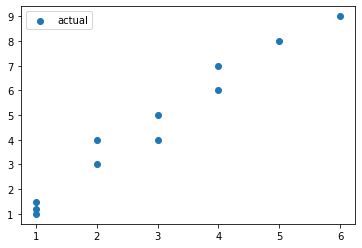

In [3]:
plt.scatter(X, y, label="actual")
plt.legend()

In [4]:
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),  # <--- use 2 because |(mean, std)| * #parameters
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],  # <--- get mean
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),  # <--- get std
          reinterpreted_batch_ndims=1)),
    ])

def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
    ])

In [5]:
model = tf.keras.Sequential([
  tfp.layers.DenseVariational(1 + 1, posterior_mean_field, prior_trainable, kl_weight=1/X.shape[0]),  # <--- use 2 because (mean, std)
  tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],  # <--- get mean
                           scale=1e-3 + tf.math.softplus(0.01 * t[...,1:]))), # <--- get std
])

negloglik = lambda y, rv_y: -rv_y.log_prob(y)

In [6]:
opt = tf.keras.optimizers.Adam(lr=0.01)
model.compile(loss="MSE", optimizer=opt)

In [7]:
model.fit(X, y, batch_size=10, epochs=1000, verbose=0)

In [8]:
pred = np.stack([model(X).mean().numpy() for _ in range(100)])

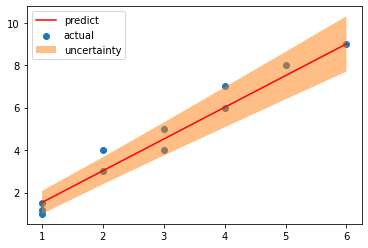

In [9]:
plt.scatter(X, y, label="actual")
plt.plot(X, pred.mean(axis=0), color='red', label="predict")
plt.fill_between(X.flatten(), 
                 (pred.mean(axis=0) + 2 * pred.std(axis=0)).flatten(), 
                 (pred.mean(axis=0) - 2 * pred.std(axis=0)).flatten(), 
                 alpha=0.5, label='uncertainty')
plt.legend()